<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/OpenMM_Scripting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**NOTE**: Code must be run twice to work

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

!mamba install -c conda-forge ambertools -y

✨🍰✨ Everything looks OK!

Looking for: ['ambertools']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed



In [3]:
!git clone https://github.com/Iourarum/GOPY.git
%cd GOPY
!python GOPY.py generate_PG 10 10 graphene.pdb
!python GOPY.py generate_GO graphene.pdb 2 4 8 functionalized.pdb

Cloning into 'GOPY'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 197 (delta 39), reused 18 (delta 18), pack-reused 150 (from 1)
Receiving objects: 100% (197/197), 9.50 MiB | 35.38 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/GOPY
done.
GOPY.py
generate_GO
graphene.pdb
2
4
8
functionalized.pdb
Left to add:  cooh:  2 epoxy:  4 hydroxyl:  8
Left to add:  cooh:  2 epoxy:  3 hydroxyl:  8
Left to add:  cooh:  2 epoxy:  3 hydroxyl:  7
Left to add:  cooh:  1 epoxy:  3 hydroxyl:  7
Left to add:  cooh:  0 epoxy:  3 hydroxyl:  7
Left to add:  cooh:  0 epoxy:  2 hydroxyl:  7
Left to add:  cooh:  0 epoxy:  1 hydroxyl:  7
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  7
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  6
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  5
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  4
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  3
Left to add:  cooh:  0 epoxy:  0

In [4]:
!wget https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/GGG.lib
!wget https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/C1A.lib
!wget https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/E1A.lib
!wget https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/H1A.lib
!mkdir -p FRCMOD
!wget -P FRCMOD https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/FRCMOD/GO.frcmod

--2025-02-11 18:02:13--  https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/GGG.lib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [text/plain]
Saving to: ‘GGG.lib’

GGG.lib             100%[===================>]   1.04K  --.-KB/s    in 0s      

2025-02-11 18:02:13 (33.1 MB/s) - ‘GGG.lib’ saved [1063/1063]

--2025-02-11 18:02:13--  https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/C1A.lib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1627 (1.6K) [text/plain]
Saving to: ‘C1A.lib’

C1

In [5]:
!pip install openmm
!pip install MDAnalysis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 108.8 MB/s eta 0:00:00


New

In [6]:
import os


leap_content_stage1 = f"""\
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 20.0
saveamberparm mol mol_solv.prmtop mol_solv.inpcrd
quit
"""
with open('leap_stage1.in', 'w') as f:
    f.write(leap_content_stage1)

os.system('tleap -f leap_stage1.in')


os.system("grep 'Volume:' leap.log > temp_vol.txt")
with open("temp_vol.txt", 'r') as f:
    for line in f:
        vol = float(line.split()[1])
vol_lit = vol * 1e-27

atom_factor = 6.022e23 * 0.15
num_Hg = int(vol_lit * atom_factor)
num_Cl = 2 * num_Hg

print(f"Computed ion counts -> Hg: {num_Hg}, Cl: {num_Cl}")


leap_content_stage2 = f"""\
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 5.0
addIonsRand mol HG {num_Hg} Cl- {num_Cl}
saveamberparm mol mol_solv_ions.prmtop mol_solv_ions.inpcrd
savepdb mol mol_solv.pdb
quit
"""
with open('leap_stage2.in', 'w') as f:
    f.write(leap_content_stage2)

os.system('tleap -f leap_stage2.in')

!tleap -f leap_stage2.in

Computed ion counts -> Hg: 15, Cl: 30
-I: Adding /usr/local/dat/leap/prep to search path.
-I: Adding /usr/local/dat/leap/lib to search path.
-I: Adding /usr/local/dat/leap/parm to search path.
-I: Adding /usr/local/dat/leap/cmd to search path.
-f: Source leap_stage2.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./leap_stage2.in
----- Source: /usr/local/dat/leap/cmd/leaprc.protein.ff14SB
----- Source of /usr/local/dat/leap/cmd/leaprc.protein.ff14SB done
Log file: ./leap.log
Loading parameters: /usr/local/dat/leap/parm/parm10.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA
Loading parameters: /usr/local/dat/leap/parm/frcmod.ff14SB
Reading force field modification type file (frcmod)
Reading title:
ff14SB protein backbone and sidechain parameters
Loading library: /usr/local/dat/leap/lib/amino12.lib
Loading library: /usr/local/dat/leap/lib/aminoct12.lib
Loading library: /usr/local/dat/leap/lib/aminont12.lib
----- Source: /usr/local/dat/leap/cmd/leaprc.

In [19]:
!pip install py3Dmol

In [31]:
import warnings
warnings.filterwarnings('ignore')
import py3Dmol

show_box = True
box_opacity = 0.3

def show_pdb(show_box=False):
    view = py3Dmol.view(width=800, height=600)
    pdb_str = open('/content/GOPY/mol_solv.pdb', 'r').read()
    view.addModel(pdb_str, 'pdb')

    view.addStyle({'resn': 'HG'}, {
        'stick': {'color': 'red', 'radius': 0.3},
        'sphere': {'color': 'red', 'radius': 0.5}
    })

    view.addStyle({'or': [{'resn': 'Cl'}, {'resn': 'Cl-'}]}, {
        'stick': {'color': 'blue', 'radius': 0.3},
        'sphere': {'color': 'blue', 'radius': 0.5}
    })

    view.addStyle({'and': [
        {'not': {'resn': 'HG'}},
        {'not': {'or': [{'resn': 'Cl'}, {'resn': 'Cl-'}]}},
        {'not': {'resn': 'HOH'}}
    ]}, {
        'cartoon': {'color': 'sandybrown', 'thickness': 1}
    })

    view.setViewStyle({'style': 'outline', 'color': 'black', 'width': 0.1})

    if show_box:
        view.addSurface(py3Dmol.SAS, {'opacity': box_opacity, 'color': 'white'})

    view.zoomTo()
    return view

show_pdb(show_box).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [27]:
import os
import py3Dmol

pdb_file = os.path.join(os.getcwd(), "mol_solv.pdb")

with open(pdb_file, 'r') as f:
    pdb_data = f.read()

view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_data, "pdb")

# Apply styles
view.setStyle({'stick': {'colorscheme': 'cyanCarbon', 'radius': 0.3}})
view.addStyle({'sphere': {'radius': 0.5}}, {'resn': 'HG'})
view.addStyle({'sphere': {'radius': 0.3, 'color': 'red'}}, {'resn': 'CL'})

# Enhance visualization
view.setViewStyle({'style': 'outline', 'color': 'black', 'width': 0.1})
view.zoomTo()

# Show the visualization
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [32]:
# Modified sorption isotherm code with molarity-based initialization
import os
from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PDBReporter, PME, HBonds, DCDReporter
from openmm import LangevinMiddleIntegrator, Platform
from openmm.unit import kelvin, picosecond, nanometer, picoseconds
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.signal import find_peaks
from scipy.spatial import cKDTree
from scipy.constants import Avogadro
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

def run_simulation_and_analyze(molarity, mass_adsorbent=1.0):
    # Stage 1: Determine system volume
    leap_stage1 = f"""\
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 20.0
saveamberparm mol mol_solv_stage1.prmtop mol_solv_stage1.inpcrd
quit
"""
    with open('leap_stage1.in', 'w') as f:
        f.write(leap_stage1)
    os.system('tleap -f leap_stage1.in')

    # Extract volume and calculate ion counts
    os.system("grep 'Volume:' leap.log > temp_vol.txt")
    with open("temp_vol.txt", 'r') as f:
        vol = float(f.readline().split()[1])

    vol_lit = vol * 1e-27  # Convert Å³ to liters
    num_Hg = int(vol_lit * molarity * Avogadro)
    num_Cl = 2 * num_Hg

    # Stage 2: Add ions and run simulation
    leap_stage2 = f"""\
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 5.0
addIonsRand mol HG {num_Hg} Cl- {num_Cl}
saveamberparm mol mol_solv_ions.prmtop mol_solv_ions.inpcrd
quit
"""
    with open('leap_stage2.in', 'w') as f:
        f.write(leap_stage2)
    os.system('tleap -f leap_stage2.in')

    # Simulation setup
    prmtop = AmberPrmtopFile('mol_solv_ions.prmtop')
    inpcrd = AmberInpcrdFile('mol_solv_ions.inpcrd')

    system = prmtop.createSystem(nonbondedMethod=PME,
                                nonbondedCutoff=1.0*nanometer,
                                constraints=HBonds)
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
    platform = Platform.getPlatformByName('CPU')
    simulation = Simulation(prmtop.topology, system, integrator, platform)
    simulation.context.setPositions(inpcrd.positions)
    simulation.minimizeEnergy()

    # Production dynamics
    simulation.reporters.append(DCDReporter('trajectory.dcd', 100))
    simulation.step(5000)

    # Analysis
    u = mda.Universe('mol_solv_ions.prmtop', 'trajectory.dcd')
    protein = u.select_atoms('resname GGG E1A H1A C1A')
    HG = u.select_atoms('name HG')

    # RDF analysis
    rdf_calc = InterRDF(protein, HG, range=(0.0, 12.0), nbins=120)
    rdf_calc.run()

    # Adsorption calculation
    adsorbed = 0
    total_frames = 0
    box_dims = u.trajectory[0].dimensions[:3]

    for ts in u.trajectory:
        tr_ref = cKDTree(protein.positions)
        tr_tg = cKDTree(HG.positions)
        sdm = tr_ref.sparse_distance_matrix(tr_tg, max_distance=5.0, output_type='coo_matrix')
        adsorbed += len(np.unique(sdm.col))
        total_frames += 1

    avg_adsorbed = adsorbed / total_frames if total_frames > 0 else 0.0

    # Calculate isotherm values
    volume_A3 = box_dims[0] * box_dims[1] * box_dims[2]
    volume_L = volume_A3 * 1e-27  # Correct conversion to liters
    MW_HG = 200.59  # Mercury atomic weight

    C_e = (num_Hg - avg_adsorbed) * MW_HG / (Avogadro * volume_L) * 1e3  # mg/L
    q_e = (avg_adsorbed * MW_HG) / mass_adsorbent * 1e3  # mg/g

    return C_e, q_e, rdf_calc.bins, rdf_calc.rdf

Molarity: 0.05 M, Ce: -208304.96 mg/L, qe: 2017935.40 mg/g
Molarity: 0.1 M, Ce: -203749.59 mg/L, qe: 1973805.60 mg/g
Molarity: 0.15 M, Ce: 0.00 mg/L, qe: 200590.00 mg/g
Molarity: 0.2 M, Ce: 414.13 mg/L, qe: 196578.20 mg/g


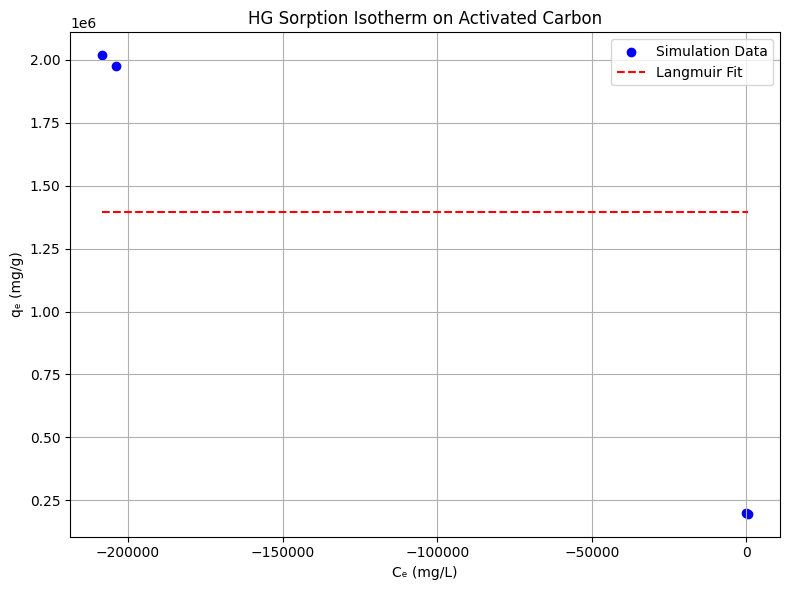

Langmuir fit parameters:
q_max = 1396106.39 mg/g
K_L = -210734.8943 L/mg


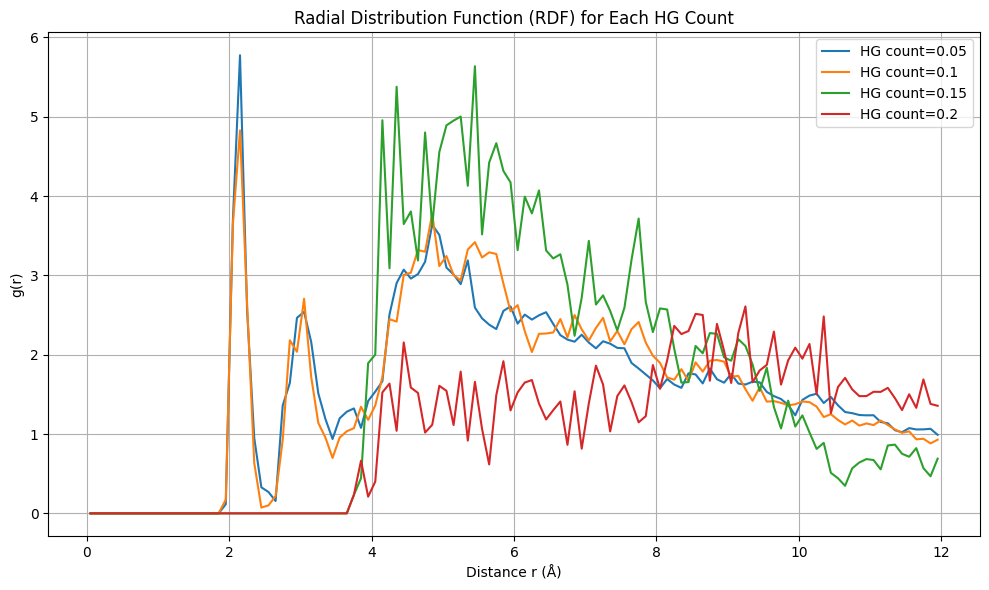

In [33]:
# Main execution loop for molarity trials
molarities = [0.05, 0.10, 0.15, 0.20]  # Molar concentrations to test
Ce_values = []
qe_values = []
rdf_data = []

for molarity in molarities:
    Ce, qe, r, rdf = run_simulation_and_analyze(molarity)
    Ce_values.append(Ce)
    qe_values.append(qe)
    rdf_data.append((molarity, r, rdf))
    print(f"Molarity: {molarity} M, Ce: {Ce:.2f} mg/L, qe: {qe:.2f} mg/g")

with open('sorption_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['HG_count', 'Ce (mg/L)', 'q_e (mg/g)'])
    for count, Ce, qe in zip(HG_counts, Ce_values, qe_values):
        writer.writerow([count, Ce, qe])

def langmuir(C, q_max, K_L):
    return (q_max * K_L * C) / (1 + K_L * C)

if len(Ce_values) > 2:
    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1], maxfev=10000)
    q_max, K_L = params

    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)

    plt.figure(figsize=(8, 6))
    plt.scatter(Ce_values, qe_values, c='b', label='Simulation Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Cₑ (mg/L)')
    plt.ylabel('qₑ (mg/g)')
    plt.title('HG Sorption Isotherm on Activated Carbon')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Langmuir fit parameters:\nq_max = {q_max:.2f} mg/g\nK_L = {K_L:.4f} L/mg")

# RDF plotting for each trial
plt.figure(figsize=(10, 6))
for count, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'HG count={count}')
plt.xlabel('Distance r (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF) for Each HG Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

-I: Adding /usr/local/dat/leap/prep to search path.
-I: Adding /usr/local/dat/leap/lib to search path.
-I: Adding /usr/local/dat/leap/parm to search path.
-I: Adding /usr/local/dat/leap/cmd to search path.
-f: Source tleap.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleap.in
----- Source: /usr/local/dat/leap/cmd/leaprc.protein.ff14SB
----- Source of /usr/local/dat/leap/cmd/leaprc.protein.ff14SB done
Log file: ./leap.log
Loading parameters: /usr/local/dat/leap/parm/parm10.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA
Loading parameters: /usr/local/dat/leap/parm/frcmod.ff14SB
Reading force field modification type file (frcmod)
Reading title:
ff14SB protein backbone and sidechain parameters
Loading library: /usr/local/dat/leap/lib/amino12.lib
Loading library: /usr/local/dat/leap/lib/aminoct12.lib
Loading library: /usr/local/dat/leap/lib/aminont12.lib
----- Source: /usr/local/dat/leap/cmd/leaprc.water.tip3p
----- Source of /usr/local/dat/leap/cm

/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


HG count: 20, Ce: 2.81 mg/L, qe: 200590.00 mg/g
HG count: 40, Ce: 5.77 mg/L, qe: 200590.00 mg/g
HG count: 60, Ce: 8.68 mg/L, qe: 272802.40 mg/g
HG count: 80, Ce: 11.40 mg/L, qe: 593746.40 mg/g


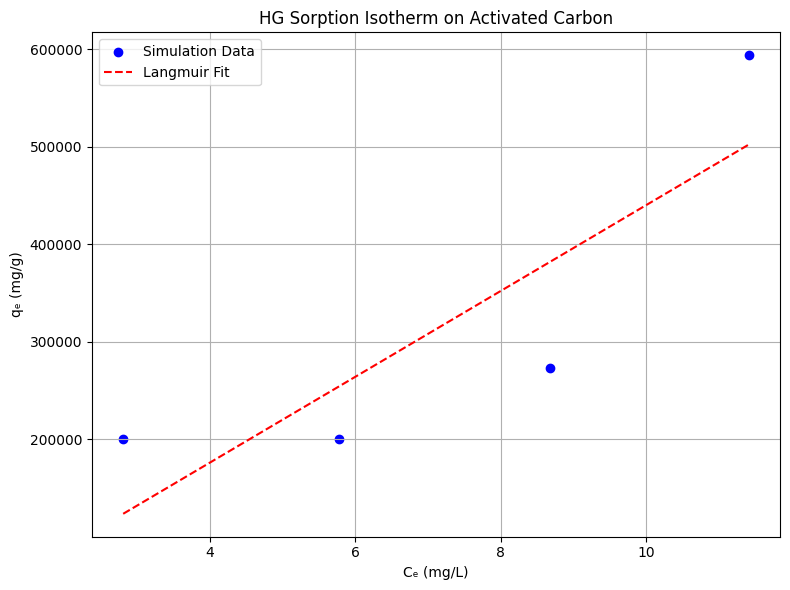

Langmuir fit parameters:
q_max = 78176052624.48 mg/g
K_L = 0.0000 L/mg


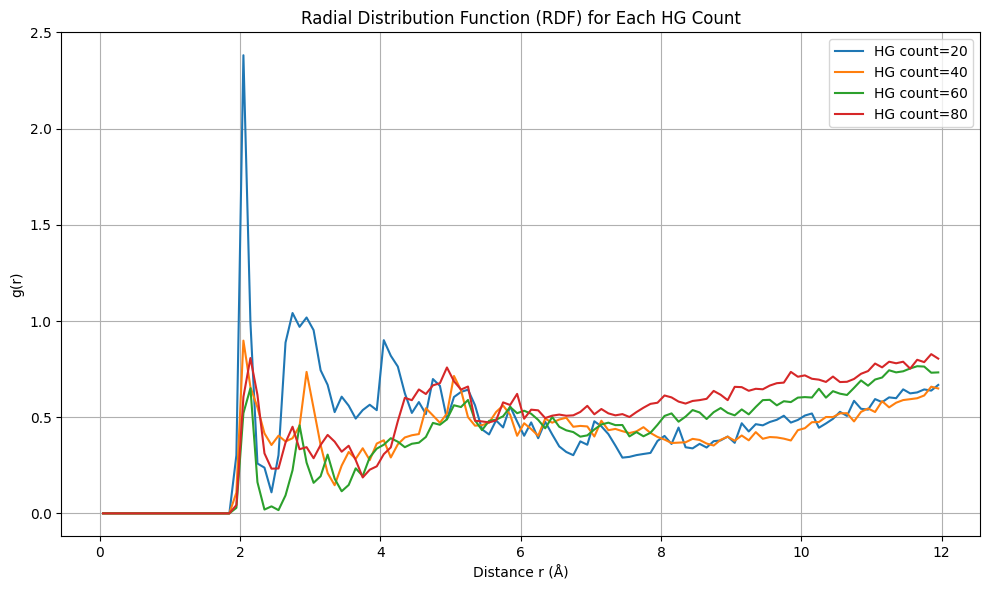

In [9]:
#Thank you to u/SocraticHope and u/qfbros on r/comp_chem for helping me debug my tleap script :)

tleap_script = """
source leaprc.protein.ff14SB

source leaprc.water.tip3p

loadAmberParams frcmod.ions234lm_126_tip3p
list
solv = createUnit solv

solvateBox solv TIP3PBOX 20.0

addIons2 solv HG 1

addIons2 solv Cl- 2

saveAmberParm solv solv.prmtop solv.inpcrd

quit
"""

with open('tleap.in', 'w') as f:
    f.write(tleap_script)

!tleap -f tleap.in

from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PDBReporter, PME, HBonds, DCDReporter
from openmm import LangevinMiddleIntegrator, Platform
from openmm.unit import kelvin, picosecond, nanometer, picoseconds
import os, numpy as np, MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.signal import find_peaks
from scipy.spatial import cKDTree
from scipy.constants import Avogadro

def run_simulation_and_analyze(HG_count, box_dims, mass_adsorbent=1.0, initial_counts=None):
    leap_content = f"""source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 5.0
addIons2 mol HG {HG_count}
addIons2 mol Cl- {2*HG_count}
saveamberparm mol mol_solv.prmtop mol_solv.inpcrd
quit
"""
    with open('leap.in', 'w') as f:
        f.write(leap_content)
    os.system('tleap -f leap.in')

    prmtop = AmberPrmtopFile('mol_solv.prmtop')
    inpcrd = AmberInpcrdFile('mol_solv.inpcrd')
    topology = prmtop.topology
    positions = inpcrd.positions

    system = prmtop.createSystem(nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
    platform = Platform.getPlatformByName('CPU')
    simulation = Simulation(topology, system, integrator, platform)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()

    # Use DCDReporter to generate a trajectory file with consistent atom counts
    simulation.reporters.append(DCDReporter('trajectory.dcd', 100))
    simulation.step(5000)

    # Load the trajectory using MDAnalysis with the same topology
    u = mda.Universe('mol_solv.prmtop', 'trajectory.dcd')
    for ts in u.trajectory:
        ts.dimensions = [box_dims[0], box_dims[1], box_dims[2], 90.0, 90.0, 90.0]
    u.trajectory.rewind()

    protein = u.select_atoms('resname GGG E1A H1A C1A')
    HG = u.select_atoms('name HG')

    # RDF computation
    r_min, r_max = 0.0, 12.0
    rdf_calc = InterRDF(protein, HG, range=(r_min, r_max), nbins=120)
    rdf_calc.run()

    peaks, _ = find_peaks(rdf_calc.rdf)
    if len(peaks) > 0:
        first_peak = peaks[0]
        inverted = -rdf_calc.rdf
        minima, _ = find_peaks(inverted, distance=10)
        cands = minima[minima > first_peak]
        r_cut = rdf_calc.bins[cands[0]] if len(cands) > 0 else r_max
    else:
        r_cut = r_max

    adsorbed = 0
    total_frames = 0
    ref_group = protein
    target_group = HG
    for ts in u.trajectory:
        p_ref = ref_group.positions
        p_tg = target_group.positions
        tr_ref = cKDTree(p_ref)
        tr_tg = cKDTree(p_tg)
        sdm = tr_ref.sparse_distance_matrix(tr_tg, max_distance=r_cut, output_type='coo_matrix')
        col_ids = np.unique(sdm.col)
        adsorbed += len(col_ids)
        total_frames += 1

    avg_adsorbed = adsorbed / total_frames if total_frames > 0 else 0.0

    MW_HG = 200.59
    if initial_counts is None:
        initial_counts = {'HG': HG_count}
    N_initial = initial_counts['HG']

    volume_A3 = box_dims[0] * box_dims[1] * box_dims[2]
    volume_L = volume_A3 * 1e-24
    N_unads = N_initial - avg_adsorbed
    C_e = (N_unads * MW_HG / Avogadro) / volume_L * 1e3  # mg/L
    q_e = (avg_adsorbed * MW_HG) / mass_adsorbent * 1e3  # mg/g

    return C_e, q_e, rdf_calc.bins, rdf_calc.rdf

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

HG_counts = [20, 40, 60, 80]
box_dims = (150.0, 150.0, 100.0)
Ce_values = []
qe_values = []
rdf_data = []

for count in HG_counts:
    Ce, qe, r, rdf = run_simulation_and_analyze(count, box_dims, mass_adsorbent=1.0, initial_counts={'HG': count})
    Ce_values.append(Ce)
    qe_values.append(qe)
    rdf_data.append((count, r, rdf))
    print(f"HG count: {count}, Ce: {Ce:.2f} mg/L, qe: {qe:.2f} mg/g")

with open('sorption_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['HG_count', 'Ce (mg/L)', 'q_e (mg/g)'])
    for count, Ce, qe in zip(HG_counts, Ce_values, qe_values):
        writer.writerow([count, Ce, qe])

def langmuir(C, q_max, K_L):
    return (q_max * K_L * C) / (1 + K_L * C)

if len(Ce_values) > 2:
    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1], maxfev=10000)
    q_max, K_L = params

    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)

    plt.figure(figsize=(8, 6))
    plt.scatter(Ce_values, qe_values, c='b', label='Simulation Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Cₑ (mg/L)')
    plt.ylabel('qₑ (mg/g)')
    plt.title('HG Sorption Isotherm on Activated Carbon')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Langmuir fit parameters:\nq_max = {q_max:.2f} mg/g\nK_L = {K_L:.4f} L/mg")

# RDF plotting for each trial
plt.figure(figsize=(10, 6))
for count, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'HG count={count}')
plt.xlabel('Distance r (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF) for Each HG Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Updated params

/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/rdf.py:347: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/rdf.py:339: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)


Initial C0: 4.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g
Initial C0: 8.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g
Initial C0: 12.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g
Initial C0: 16.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g
Initial C0: 20.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g


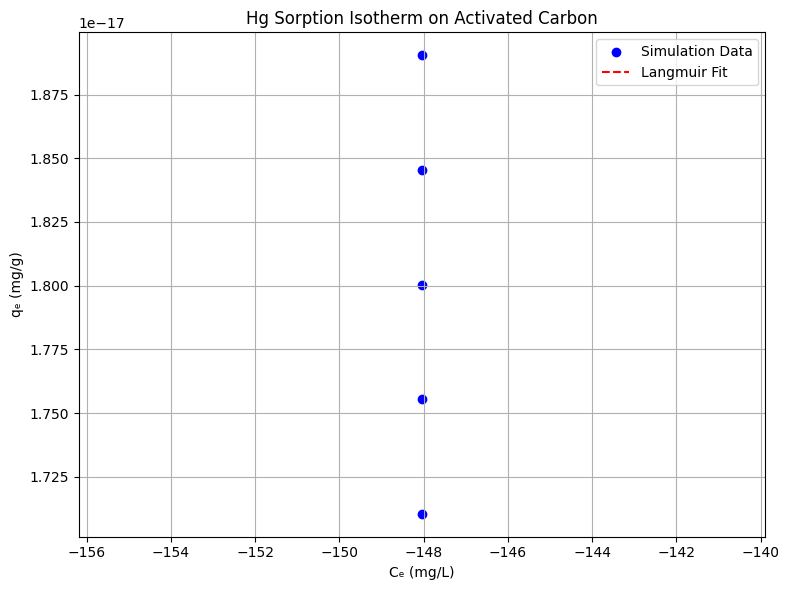

Langmuir fit parameters:
  q_max = 0.00 mg/g
  K_L = 0.1000 L/mg


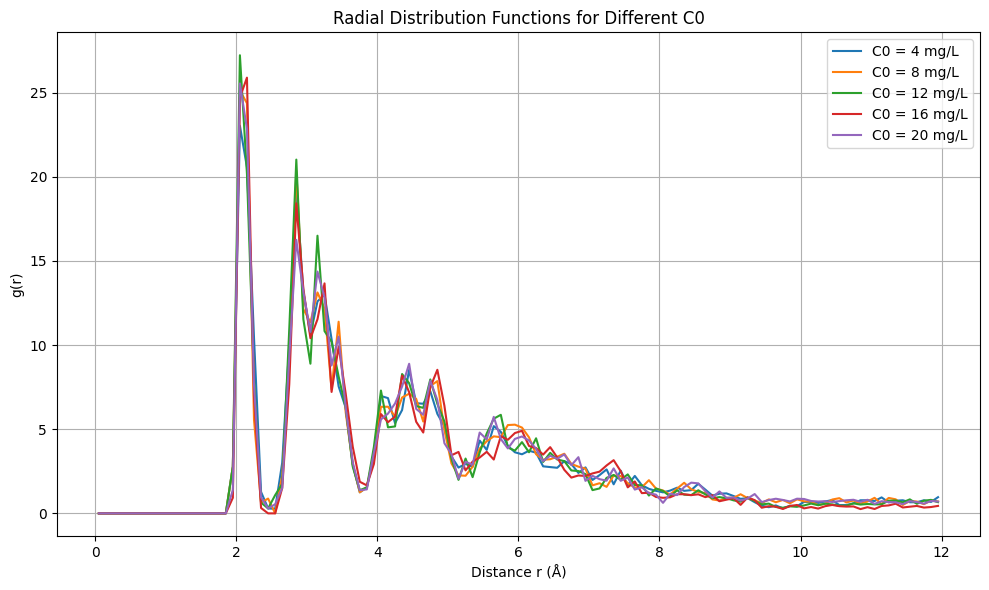

In [7]:
#!/usr/bin/env python
import os, numpy as np, MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.signal import find_peaks
from scipy.spatial import cKDTree
from scipy.constants import Avogadro
from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PDBReporter, PME, HBonds, DCDReporter
from openmm import LangevinMiddleIntegrator, Platform
from openmm.unit import kelvin, picosecond, nanometer, picoseconds
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

# --- Constants & Parameters ---
MW_Hg = 200.59  # g/mol
mass_adsorbent = 0.02
initial_concs = [4, 8, 12, 16, 20]
box_dims = (150.0, 150.0, 100.0)
volume_A3 = box_dims[0] * box_dims[1] * box_dims[2]
V = volume_A3 * 1e-27  # L

def run_simulation_and_analyze(C0, box_dims, mass_adsorbent):
    N_initial = int(round((C0 * V * Avogadro) / (MW_Hg * 1e3)))
    Cl_count = 2 * N_initial

    leap_content = f"""
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 5.0
addIons2 mol HG {N_initial}
addIons2 mol Cl- {Cl_count}
saveamberparm mol mol_solv.prmtop mol_solv.inpcrd
quit
"""
    with open('leap.in', 'w') as f:
        f.write(leap_content)
    os.system('tleap -f leap.in')

    prmtop = AmberPrmtopFile('mol_solv.prmtop')
    inpcrd = AmberInpcrdFile('mol_solv.inpcrd')
    topology = prmtop.topology
    positions = inpcrd.positions
    system = prmtop.createSystem(nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
    platform = Platform.getPlatformByName('CPU')
    simulation = Simulation(topology, system, integrator, platform)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()
    simulation.reporters.append(DCDReporter('trajectory.dcd', 100))
    simulation.step(5000)

    u = mda.Universe('mol_solv.prmtop', 'trajectory.dcd')
    for ts in u.trajectory:
        ts.dimensions = [box_dims[0], box_dims[1], box_dims[2], 90.0, 90.0, 90.0]
    u.trajectory.rewind()

    adsorbent = u.select_atoms('resname GGG E1A H1A C1A')
    HG = u.select_atoms('name HG')

    r_min, r_max = 0.0, 12.0
    rdf_calc = InterRDF(adsorbent, HG, range=(r_min, r_max), nbins=120)
    rdf_calc.run()
    peaks, _ = find_peaks(rdf_calc.rdf)
    if len(peaks) > 0:
        first_peak = peaks[0]
        inverted = -rdf_calc.rdf
        minima, _ = find_peaks(inverted, distance=10)
        cands = minima[minima > first_peak]
        r_cut = rdf_calc.bins[cands[0]] if len(cands) > 0 else r_max
    else:
        r_cut = r_max

    adsorbed_total = 0
    frames_count = 0
    for ts in u.trajectory:
        pos_ads = adsorbent.positions
        pos_Hg = HG.positions
        tree_ads = cKDTree(pos_ads)
        tree_Hg = cKDTree(pos_Hg)
        sd_matrix = tree_ads.sparse_distance_matrix(tree_Hg, max_distance=r_cut, output_type='coo_matrix')
        adsorbed_ids = np.unique(sd_matrix.col)
        adsorbed_total += len(adsorbed_ids)
        frames_count += 1
    avg_adsorbed = adsorbed_total / frames_count if frames_count else 0
    N_unads = N_initial - avg_adsorbed

    Ce = (N_unads * MW_Hg / Avogadro) / V * 1e3

    qe = ((C0 - Ce) * V) / mass_adsorbent

    return Ce, qe, rdf_calc.bins, rdf_calc.rdf

Ce_values, qe_values, rdf_data = [], [], []

for C0 in initial_concs:
    Ce, qe, r, rdf = run_simulation_and_analyze(C0, box_dims, mass_adsorbent)
    Ce_values.append(Ce)
    qe_values.append(qe)
    rdf_data.append((C0, r, rdf))
    print(f"Initial C0: {C0:.2f} mg/L, Equilibrium Ce: {Ce:.2f} mg/L, q_e: {qe:.2f} mg/g")

with open('sorption_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['C0 (mg/L)', 'Ce (mg/L)', 'q_e (mg/g)'])
    for C0, Ce, qe in zip(initial_concs, Ce_values, qe_values):
        writer.writerow([C0, Ce, qe])

def langmuir(C, q_max, K_L):
    return (q_max * K_L * C) / (1 + K_L * C)

if len(Ce_values) > 2:
    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1], maxfev=10000)
    q_max, K_L = params
    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)
    plt.figure(figsize=(8, 6))
    plt.scatter(Ce_values, qe_values, c='b', label='Simulation Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Cₑ (mg/L)')
    plt.ylabel('qₑ (mg/g)')
    plt.title('Hg Sorption Isotherm on Activated Carbon')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"Langmuir fit parameters:\n  q_max = {q_max:.2f} mg/g\n  K_L = {K_L:.4f} L/mg")

plt.figure(figsize=(10, 6))
for C0, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'C0 = {C0} mg/L')
plt.xlabel('Distance r (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Functions for Different C0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#new

In [14]:
import os
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.spatial import cKDTree
from scipy.constants import Avogadro
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PME, HBonds, DCDReporter
from openmm import LangevinMiddleIntegrator, Platform
from openmm.unit import kelvin, picosecond, nanometer, picoseconds

def parse_box_from_inpcrd(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    # Last line should contain 6 numbers if box info exists.
    last_line = lines[-1].strip().split()
    if len(last_line) == 6:
        try:
            Lx, Ly, Lz, a, b, c = map(float, last_line)
            return np.array([Lx, Ly, Lz])
        except Exception:
            return None
    return None

def run_simulation_and_analyze(molarity, mass_adsorbent=1.0):
    solvation_buffer = 5.0

    # Stage 1: Create solvated system (no ions) to get box volume.
    leap_no_ions = f"""\
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX {solvation_buffer}
saveamberparm mol mol_solv_no_ions.prmtop mol_solv_no_ions.inpcrd
quit
"""
    with open('leap_no_ions.in', 'w') as f:
        f.write(leap_no_ions)
    os.system('tleap -f leap_no_ions.in > leap_no_ions.log')

    u0 = mda.Universe('mol_solv_no_ions.prmtop', 'mol_solv_no_ions.inpcrd')
    # Try to use MDAnalysis dimensions; if missing, parse the inpcrd manually.
    box_dims = u0.trajectory[0].dimensions
    if box_dims is None or not np.any(box_dims):
        parsed = parse_box_from_inpcrd('mol_solv_no_ions.inpcrd')
        if parsed is not None:
            box_dims = parsed
        else:
            # Fallback: use the bounding box of atom positions.
            positions = u0.atoms.positions
            box_dims = positions.max(axis=0) - positions.min(axis=0)
    else:
        box_dims = box_dims[:3]
    volume_A3 = np.prod(box_dims)
    volume_L = volume_A3 * 1e-27  # Convert Å³ to L

    num_Hg = int(volume_L * molarity * Avogadro)
    num_Cl = 2 * num_Hg

    # Stage 2: Create system with ions.
    leap_with_ions = f"""\
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX {solvation_buffer}
addIonsRand mol HG {num_Hg} Cl- {num_Cl}
saveamberparm mol mol_solv_ions.prmtop mol_solv_ions.inpcrd
quit
"""
    with open('leap_with_ions.in', 'w') as f:
        f.write(leap_with_ions)
    os.system('tleap -f leap_with_ions.in > leap_with_ions.log')

    # Run simulation with OpenMM.
    prmtop = AmberPrmtopFile('mol_solv_ions.prmtop')
    inpcrd = AmberInpcrdFile('mol_solv_ions.inpcrd')
    system = prmtop.createSystem(nonbondedMethod=PME,
                                 nonbondedCutoff=1.0*nanometer,
                                 constraints=HBonds)
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
    platform = Platform.getPlatformByName('CPU')
    simulation = Simulation(prmtop.topology, system, integrator, platform)
    simulation.context.setPositions(inpcrd.positions)
    simulation.minimizeEnergy()
    simulation.reporters.append(DCDReporter('trajectory.dcd', 100))
    simulation.step(5000)

    # Retrieve simulation box dimensions from OpenMM.
    state = simulation.context.getState(getBoxVectors=True)
    box_vectors = state.getPeriodicBoxVectors()
    Lx = box_vectors[0].norm().value_in_unit(nanometer) * 10.0  # convert nm to Å
    Ly = box_vectors[1].norm().value_in_unit(nanometer) * 10.0
    Lz = box_vectors[2].norm().value_in_unit(nanometer) * 10.0
    volume_A3_sim = Lx * Ly * Lz
    volume_L_sim = volume_A3_sim * 1e-27

    # Analysis with MDAnalysis.
    u = mda.Universe('mol_solv_ions.prmtop', 'trajectory.dcd')
    # Set box dimensions manually (DCD may not contain them)
    u.dimensions = np.array([Lx, Ly, Lz, 90, 90, 90])
    adsorbent = u.select_atoms('resname GGG E1A H1A C1A')
    HG = u.select_atoms('name HG')

    rdf_calc = InterRDF(adsorbent, HG, range=(0.0, 12.0), nbins=120)
    rdf_calc.run()

    adsorbed_counts = []
    for ts in u.trajectory:
        tree_ads = cKDTree(adsorbent.positions)
        tree_HG = cKDTree(HG.positions)
        pairs = tree_ads.query_ball_tree(tree_HG, r=5.0)
        # Unique HG indices within 5 Å of any adsorbent atom.
        hg_indices = {idx for sub in pairs for idx in sub}
        adsorbed_counts.append(len(hg_indices))
    avg_adsorbed = np.mean(adsorbed_counts)

    MW_HG = 200.59  # g/mol
    num_unadsorbed = num_Hg - avg_adsorbed
    C_e = (num_unadsorbed/Avogadro * MW_HG * 1e3) / volume_L_sim  # mg/L
    q_e = (avg_adsorbed/Avogadro * MW_HG * 1e3) / mass_adsorbent     # mg/g

    return C_e, q_e, rdf_calc.bins, rdf_calc.rdf, num_Hg

In [ ]:
# Main execution loop.
molarities = [0.05, 0.10, 0.15, 0.20]
Ce_values, qe_values, rdf_data, ion_counts = [], [], [], []

for molarity in molarities:
    Ce, qe, r, rdf, count = run_simulation_and_analyze(molarity)
    Ce_values.append(Ce)
    qe_values.append(qe)
    rdf_data.append((molarity, r, rdf))
    ion_counts.append(count)
    print(f"Molarity: {molarity} M, Ce: {Ce:.2f} mg/L, qₑ: {qe:.2f} mg/g")

with open('sorption_data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Num_Hg', 'Cₑ (mg/L)', 'qₑ (mg/g)'])
    for count, Ce, qe in zip(ion_counts, Ce_values, qe_values):
        writer.writerow([count, Ce, qe])

def langmuir(C, q_max, K_L):
    return (q_max * K_L * C) / (1 + K_L * C)

if len(Ce_values) > 2:
    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1], maxfev=10000)
    q_max, K_L = params
    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)
    plt.figure(figsize=(8, 6))
    plt.scatter(Ce_values, qe_values, color='b', label='Simulation Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Cₑ (mg/L)')
    plt.ylabel('qₑ (mg/g)')
    plt.title('Hg Sorption Isotherm')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"Langmuir fit parameters:\n  q_max = {q_max:.2f} mg/g\n  K_L = {K_L:.4f} L/mg")

plt.figure(figsize=(10, 6))
for molarity, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'Molarity={molarity} M')
plt.xlabel('Distance r (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function for Hg')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Faster

In [21]:
import os
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.spatial import cKDTree
from scipy.constants import Avogadro
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PME, HBonds, DCDReporter
from openmm import LangevinMiddleIntegrator, Platform
from openmm.unit import kelvin, picosecond, nanometer, picoseconds

def parse_box_from_inpcrd(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    last_line = lines[-1].strip().split()
    if len(last_line) == 6:
        try:
            Lx, Ly, Lz, _, _, _ = map(float, last_line)
            return np.array([Lx, Ly, Lz])
        except Exception:
            return None
    return None

def run_simulation_and_analyze(molarity, mass_adsorbent=1.0, frame_skip=2):
    solvation_buffer = 20.0

    leap_no_ions = f"""\
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX {solvation_buffer}
saveamberparm mol mol_solv_no_ions.prmtop mol_solv_no_ions.inpcrd
quit
"""
    with open('leap_no_ions.in', 'w') as f:
        f.write(leap_no_ions)
    os.system('tleap -f leap_no_ions.in > leap_no_ions.log')

    u0 = mda.Universe('mol_solv_no_ions.prmtop', 'mol_solv_no_ions.inpcrd')
    box_dims = u0.trajectory[0].dimensions
    if box_dims is None or not np.any(box_dims):
        parsed = parse_box_from_inpcrd('mol_solv_no_ions.inpcrd')
        box_dims = parsed if parsed is not None else (u0.atoms.positions.max(axis=0) - u0.atoms.positions.min(axis=0))
    else:
        box_dims = box_dims[:3]
    volume_A3 = np.prod(box_dims)
    volume_L = volume_A3 * 1e-27

    num_Hg = int(volume_L * molarity * Avogadro)
    num_Cl = 2 * num_Hg

    leap_with_ions = f"""\
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX {solvation_buffer}
addIonsRand mol HG {num_Hg} Cl- {num_Cl}
saveamberparm mol mol_solv_ions.prmtop mol_solv_ions.inpcrd
quit
"""
    with open('leap_with_ions.in', 'w') as f:
        f.write(leap_with_ions)
    os.system('tleap -f leap_with_ions.in > leap_with_ions.log')

    # Run simulation.
    prmtop = AmberPrmtopFile('mol_solv_ions.prmtop')
    inpcrd = AmberInpcrdFile('mol_solv_ions.inpcrd')
    system = prmtop.createSystem(nonbondedMethod=PME,
                                 nonbondedCutoff=1.0*nanometer,
                                 constraints=HBonds)
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
    platform = Platform.getPlatformByName('CPU')
    simulation = Simulation(prmtop.topology, system, integrator, platform)
    simulation.context.setPositions(inpcrd.positions)
    simulation.minimizeEnergy()
    simulation.reporters.append(DCDReporter('trajectory.dcd', 100))
    simulation.step(5000)

    state = simulation.context.getState(getBoxVectors=True)
    box_vectors = state.getPeriodicBoxVectors()
    Lx = box_vectors[0].norm().value_in_unit(nanometer) * 10.0  # nm->Å
    Ly = box_vectors[1].norm().value_in_unit(nanometer) * 10.0
    Lz = box_vectors[2].norm().value_in_unit(nanometer) * 10.0
    volume_A3_sim = Lx * Ly * Lz
    volume_L_sim = volume_A3_sim * 1e-27

    u = mda.Universe('mol_solv_ions.prmtop', 'trajectory.dcd')
    u.dimensions = np.array([Lx, Ly, Lz, 90, 90, 90])
    adsorbent = u.select_atoms('resname GGG E1A H1A C1A')
    HG = u.select_atoms('name HG')

    rdf_calc = InterRDF(adsorbent, HG, range=(0.0, 12.0), nbins=120)
    rdf_calc.run()

    u.trajectory.rewind()
    ads_first = adsorbent.positions.copy()
    try:
        next(u.trajectory)
        ads_second = adsorbent.positions.copy()
    except StopIteration:
        ads_second = ads_first
    static_adsorbent = np.allclose(ads_first, ads_second, atol=0.1)
    u.trajectory.rewind()
    if static_adsorbent:
        tree_ads = cKDTree(adsorbent.positions)

    # Use frame skipping to reduce the number of KDTree constructions.
    adsorbed_counts = []
    for ts in u.trajectory[::frame_skip]:
        if static_adsorbent:
            current_tree_ads = tree_ads
        else:
            current_tree_ads = cKDTree(adsorbent.positions)
        tree_HG = cKDTree(HG.positions)
        pairs = current_tree_ads.query_ball_tree(tree_HG, r=5.0)
        hg_indices = set()
        for sub in pairs:
            hg_indices.update(sub)
        adsorbed_counts.append(len(hg_indices))
    avg_adsorbed = np.mean(adsorbed_counts)

    MW_HG = 200.59  # g/mol
    num_unadsorbed = num_Hg - avg_adsorbed
    C_e = (num_unadsorbed/Avogadro * MW_HG * 1e3) / volume_L_sim  # mg/L
    q_e = (avg_adsorbed/Avogadro * MW_HG * 1e3) / mass_adsorbent     # mg/g

    return C_e, q_e, rdf_calc.bins, rdf_calc.rdf, num_Hg

In [22]:
# Main execution loop.
molarities = [0.05, 0.10, 0.15, 0.20]
Ce_values, qe_values, rdf_data, ion_counts = [], [], [], []

for molarity in molarities:
    Ce, qe, r, rdf, count = run_simulation_and_analyze(molarity, frame_skip=2)
    Ce_values.append(Ce)
    qe_values.append(qe)
    rdf_data.append((molarity, r, rdf))
    ion_counts.append(count)
    print(f"Molarity: {molarity} M, Ce: {Ce:.2f} mg/L, qₑ: {qe:.2f} mg/g")

with open('sorption_data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Num_Hg', 'Cₑ (mg/L)', 'qₑ (mg/g)'])
    for count, Ce, qe in zip(ion_counts, Ce_values, qe_values):
        writer.writerow([count, Ce, qe])

def langmuir(C, q_max, K_L):
    return (q_max * K_L * C) / (1 + K_L * C)

if len(Ce_values) > 2:
    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1], maxfev=10000)
    q_max, K_L = params
    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)
    plt.figure(figsize=(8, 6))
    plt.scatter(Ce_values, qe_values, color='b', label='Simulation Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Cₑ (mg/L)')
    plt.ylabel('qₑ (mg/g)')
    plt.title('Hg Sorption Isotherm')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"Langmuir fit parameters:\n  q_max = {q_max:.2f} mg/g\n  K_L = {K_L:.4f} L/mg")

plt.figure(figsize=(10, 6))
for molarity, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'Molarity={molarity} M')
plt.xlabel('Distance r (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function for Hg')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


TypeError: Context.getState() got an unexpected keyword argument 'getBoxVectors'